# Tools for Analytics Final Project ###

Jaeseop Shin / js6364  &. Hyunjin Jun / hj2642

## Environment Setup

In [1]:
# Importing all libraries used for the project

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import requests
import psycopg2
import pathlib
import os
import shapely

from sodapy import Socrata
from sqlalchemy import create_engine, text
from shapely.geometry import Point, Polygon
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry.base import BaseGeometry
from datetime import datetime
from dateutil.relativedelta import relativedelta

# SQL Data
db_username = "ariez"
db_name = "postgres"
db_url = f"postgresql+psycopg2://{db_username}@localhost/{db_name}"
db_schema = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1. Data Processing

### Data Setup

In [2]:
app_token = "2Hn2wwabCLXVYhGN4b9tEtJ11"


# Downloading NYC 311 data
url_311 = "data.cityofnewyork.us"
set_311 = "erm2-nwe9"
client_311 = Socrata(url_311, app_token)
client_311.timeout = 60
# Filtering data after 2015
where_311 = "date_extract_y(created_date)>=2015 AND created_date<='2023-09-30'"
# Data to data frame
data_311 = client_311.get(set_311, where=where_311, limit=4000000)
df_311 = pd.DataFrame.from_records(data_311)

# Downloading NYC Tree data
url_tree = "data.cityofnewyork.us"
set_tree = "uvpi-gqnh"
client_tree = Socrata(url_tree, app_token)
client_tree.timeout = 60
# Data to data frame
data_tree = client_tree.get(set_tree, limit = 1000000)
df_tree = pd.DataFrame.from_records(data_tree)


# Loading local data files
data_dir = pathlib.Path("data")
rent_path = data_dir / "zillow_rent_data.csv"          
df_rent = pd.read_csv(rent_path)
nyc_zipcodes_shp_path = data_dir / "nyc_zipcodes.shp"
gdf_zipcode = gpd.read_file(nyc_zipcodes_shp_path)
gdf_zipcode = gdf_zipcode.to_crs("EPSG:4326")

### Data Cleaning & Filtering 

In [3]:
def clean_filter(data_frame, column_use, column_rename, column_type):
    """Removes unnecessary columns, rename columns, confirm types of columns, discard invalid data"""
    data_frame = data_frame[column_use]
    data_frame = data_frame.rename(columns=column_rename)
    for column, dtype in column_type.items():
        if dtype == 'datetime':
            data_frame[column] = pd.to_datetime(data_frame[column], errors='coerce')
        else:
            data_frame[column] = data_frame[column].astype(dtype, errors='ignore')
    data_frame.dropna(inplace=True)
    return data_frame

In [4]:
# NYC 311 Cleaning & Filtering
# Columns to use
use_311 = [
    'unique_key',
    'created_date',
    'complaint_type',
    'incident_zip',
    'city',
    'x_coordinate_state_plane',
    'y_coordinate_state_plane',
    'latitude',
    'longitude',
]
# Columns to rename
rename_311 = {
    'unique_key': 'complaint_id',
    'created_date': 'date',
    'complaint_type': 'complaint_type',
    'incident_zip': 'zipcode',
    'city': 'city',
    'x_coordinate_state_plane': 'x_coord',
    'y_coordinate_state_plane': 'y_coord',
    'latitude': 'latitude',
    'longitude': 'longitude',
}
# Column types
type_311 = {
    'complaint_id': 'int',
    'date': 'datetime',
    'complaint_type': 'str',
    'zipcode': 'int',
    'city': 'str',
    'x_coord': 'float',
    'y_coord': 'float',
    'latitude': 'float',
    'longitude': 'float',
}

df_311_f = clean_filter(df_311, use_311, rename_311, type_311)

# Converting latitude and longitude into Geometry data
df_311_f['geometry'] = df_311_f.apply(lambda x: Point(float(x['longitude']), float(x['latitude'])), axis=1)

# Converting DataFrame to GeoDataFrame
gdf_311_f = gpd.GeoDataFrame(df_311_f, geometry='geometry')

# Setting the coordinate reference system
gdf_311_f.set_crs(epsg=4326, inplace=True)

,complaint_id,date,complaint_type,zipcode,city,x_coord,y_coord,latitude,longitude,geometry
0,58970426,2023-09-30 00:00:00,Food Poisoning,10003,NEW YORK,987037.0,207017.0,40.734890,-73.989944,POINT (-73.98994 40.73489)
1,58958037,2023-09-29 23:59:53,Noise - Residential,11433,JAMAICA,1041450.0,193016.0,40.696276,-73.793722,POINT (-73.79372 40.69628)
2,58963337,2023-09-29 23:59:40,For Hire Vehicle Complaint,10002,NEW YORK,986676.0,202759.0,40.723203,-73.991248,POINT (-73.99125 40.72320)
3,58967293,2023-09-29 23:59:10,Noise - Residential,11216,BROOKLYN,1001313.0,187243.0,40.680599,-73.938481,POINT (-73.93848 40.68060)
4,58957297,2023-09-29 23:59:00,For Hire Vehicle Complaint,10002,NEW YORK,986676.0,202759.0,40.723203,-73.991248,POINT (-73.99125 40.72320)
...,...,...,...,...,...,...,...,...,...,...
3999995,54611798,2022-06-27 14:41:00,Air Quality,10470,BRONX,1019063.0,266787.0,40.898874,-73.874073,POINT (-73.87407 40.89887)
3999996,54612982,2022-06-27 14:41:00,Noise,11420,SOUTH OZONE PARK,1031210.0,186866.0,40.679456,-73.830693,POINT (-73.83069 40.67946)
3999997,54617722,2022-06-27 14:41:00,Water System,10455,BRONX,1009673.0,235504.0,40.813043,-73.908157,POINT (-73.90816 40.81304)
3999998,54617496,2022-06-27 14:40:59,Encampment,10016,NEW YORK,988500.0,210848.0,40.745405,-73.984662,POINT (-73.98466 40.74540)


In [6]:
# NYC Tree Cleaning & Filtering
# Columns to use
use_tree = [
    'tree_id',
    'status',
    'health',
    'spc_common',
    'zipcode',
    'zip_city',
    'latitude',
    'longitude',
    'x_sp',
    'y_sp',
]
# Columns to rename
rename_tree = {
    'tree_id': 'tree_id',
    'status': 'status',
    'health': 'health',
    'spc_common': 'species',
    'zipcode': 'zipcode',
    'zip_city': 'city',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'x_sp': 'x_coord',
    'y_sp': 'y_coord',
}
# Column types
type_tree = {
    'tree_id': 'int',
    'status': 'str',
    'health': 'str',
    'species': 'str',
    'zipcode': 'int',
    'city': 'str',
    'latitude': 'float',
    'longitude': 'float',
    'x_coord': 'float',
    'y_coord': 'float',
}

df_tree_f = clean_filter(df_tree, use_tree, rename_tree, type_tree)

# Converting latitude and longitude into Geometry data
df_tree_f['geometry'] = df_tree_f.apply(lambda x: Point(float(x['longitude']), float(x['latitude'])), axis=1)

# Converting DataFrame to GeoDataFrame
gdf_tree_f = gpd.GeoDataFrame(df_tree_f, geometry='geometry')

# Setting the coordinate reference system
gdf_tree_f.set_crs(epsg=4326, inplace=True)

,tree_id,status,health,species,zipcode,city,latitude,longitude,x_coord,y_coord,geometry
0,180683,Alive,Fair,red maple,11375,Forest Hills,40.723092,-73.844215,1.027431e+06,202756.7687,POINT (-73.84422 40.72309)
1,200540,Alive,Fair,pin oak,11357,Whitestone,40.794111,-73.818679,1.034456e+06,228644.8374,POINT (-73.81868 40.79411)
2,204026,Alive,Good,honeylocust,11211,Brooklyn,40.717581,-73.936608,1.001823e+06,200716.8913,POINT (-73.93661 40.71758)
3,204337,Alive,Good,honeylocust,11211,Brooklyn,40.713537,-73.934456,1.002420e+06,199244.2531,POINT (-73.93446 40.71354)
4,189565,Alive,Good,American linden,11215,Brooklyn,40.666778,-73.975979,9.909138e+05,182202.4260,POINT (-73.97598 40.66678)
...,...,...,...,...,...,...,...,...,...,...,...
683783,155433,Alive,Good,pin oak,11211,Brooklyn,40.713211,-73.954944,9.967407e+05,199121.6363,POINT (-73.95494 40.71321)
683784,183795,Alive,Good,Kentucky yellowwood,11375,Forest Hills,40.715194,-73.856650,1.023989e+06,199873.6475,POINT (-73.85665 40.71519)
683785,166161,Alive,Good,red maple,10314,Staten Island,40.620762,-74.136517,9.463514e+05,165466.0763,POINT (-74.13652 40.62076)
683786,184028,Alive,Good,red maple,10457,Bronx,40.850828,-73.903115,1.011054e+06,249271.9507,POINT (-73.90311 40.85083)


In [42]:
# Zillow Rent Cleaning & Filtering
# Columns to remove
remove_rent = [
    'RegionID',
    'SizeRank',
    'RegionType',
    'StateName',
    'Metro',
    'CountyName',
]
# Columns to rename
rename_rent = {
    'RegionName': 'zipcode',
    'State': 'state',
    'City': 'city',
}
# Column types
type_rent = {
    'zipcode': 'int',
    'state': 'str',
    'city': 'str'
}

# Removing and renaming columns
df_rent_f = df_rent.drop(columns=remove_rent, axis=1)
df_rent_f = df_rent_f.rename(columns=rename_rent)
# Confirming Data type
for column, dtype in type_rent.items():
    df_rent_f[column] = df_rent_f[column].astype(dtype, errors='raise')
for column in df_rent_f.iloc[:, 3:]:
    df_rent_f[column] = df_rent_f[column].astype('float', errors='raise')
# Filtering for NY / NYC
df_rent_f = df_rent_f.loc[(df_rent_f['state'] == "NY") & (df_rent_f['city'] == "New York")]

,zipcode,state,city,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
4,11385,NY,New York,NaN,2087.527084,NaN,2149.924252,2166.263698,2148.992886,2190.098591,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783
6,11208,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2508.670432,2588.030194,2613.790654,2585.561351,2633.200754,2672.038493,2806.918757,2765.224364,2737.547470,2728.733333
12,11236,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2285.460026,2362.500000
13,10467,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2145.642295,2155.617718,2172.346611,2160.962748,2110.533203,2180.323655,2276.372290,2334.204728,2353.686402,2423.888889
14,11373,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2199.459063,2255.604528,2262.101623,2271.514956,2250.182334,2231.959479,2257.413993,2247.592851,2302.557354,2292.994444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,10282,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7058.613416,7143.347680,7408.940270,7459.080381,7512.509440,7452.333390,7572.806191,7611.834625,7444.236260,7347.458333
6561,11109,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4247.334177,4159.759749,4157.528579,4201.199144,4294.386817,4343.065214,4357.893069,4445.207586,4490.367074,4529.358974
6644,10006,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3936.629997,3747.416799,3693.121513,3812.835588,3920.619972,4025.134283,4043.838704,4035.676503,4042.831474,4060.096154
6695,10162,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4871.181752,5007.415824,NaN,4984.693932,5011.666667


In [8]:
# Zipcode Cleaning & Filtering
# Columns to use
use_gdf = [
    'ZIPCODE',
    'PO_NAME',
    'STATE',
    'COUNTY',
    'geometry',
]
# Columns to rename
rename_gdf = {
    'ZIPCODE': 'zipcode',
    'PO_NAME': 'city',
    'STATE': 'state',
    'COUNTY': 'county',
    'geometry': 'geometry',
}
# Column types
type_gdf = {
    'zipcode': 'int',
    'city': 'str',
    'state': 'str',
    'county': 'str',
    'geometry': 'geometry',
}

gdf_zipcode_f = clean_filter(gdf_zipcode, use_gdf, rename_gdf, type_gdf)

## Part 2. Storing Data

In [9]:
def setup_new_postgis_database(user_name, db_name):
    """Dropping Database if already exists"""
    os.system(f"dropdb -U {user_name} --if-exists {db_name}")
    """Setting up a new PostGis Database"""
    os.system(f"createdb -U {user_name} {db_name}")
    os.system(f"psql -U {user_name} --dbname {db_name} -c 'CREATE EXTENSION postgis;'")

In [11]:
setup_new_postgis_database(db_username, db_name)

CREATE EXTENSION


### Creating Tables

In [12]:
engine = create_engine(db_url)

In [13]:
# Defining the SQL statements to create 311, tree, rent, and zipcode tables
# NYC 311 Schema
nyc_311_schema = """
CREATE TABLE IF NOT EXISTS nyc_311 
(
    complaint_id INTEGER PRIMARY KEY,
    date DATE,
    complaint_type TEXT,
    zipcode INTEGER,
    city TEXT,
    x_coord INTEGER,
    y_coord INTEGER,
    latitude FLOAT,
    longitude FLOAT,
    geometry GEOMETRY(Point, 4326)
);

CREATE INDEX IF NOT EXISTS idx_nyc_311_geom ON nyc_311 USING GIST (geometry);
"""
# NYC Tree Schema
nyc_tree_schema = """
CREATE TABLE IF NOT EXISTS nyc_tree
(
    tree_id INTEGER PRIMARY KEY,
    status TEXT,
    health TEXT,
    species TEXT,
    zipcode INTEGER,
    city TEXT,
    latitude FLOAT,
    longitude FLOAT,
    x_coord FLOAT,
    y_coord FLOAT,
    geometry GEOMETRY(Point, 4326)
);

CREATE INDEX IF NOT EXISTS idx_nyc_tree_geom ON nyc_tree USING GIST (geometry);
"""

# NYC Rent Schema
# Start and end dates
start_date = datetime(2015, 1, 31)
end_date = datetime(2023, 9, 30)

# Generate monthly dates between start and end
current_date = start_date
dates = []
while current_date <= end_date:
    date_str = current_date.strftime('"%Y-%m-%d" FLOAT')
    dates.append(date_str)
    current_date += relativedelta(months=1)

# Create the schema with generated dates
nyc_rent_schema = """
CREATE TABLE IF NOT EXISTS nyc_rent
(
    zipcode INTEGER PRIMARY KEY,
    state TEXT,
    city TEXT,
    {}
)
""".format(",\n    ".join(dates))

# NYC Zipcode Schema
nyc_zipcode_schema = """
CREATE TABLE IF NOT EXISTS nyc_zipcode
(
    zipcode INTEGER PRIMARY KEY,
    city TEXT,
    state TEXT,
    county TEXT,
    geometry GEOMETRY(Polygon, 4326)
);

CREATE INDEX IF NOT EXISTS idx_nyc_zipcode_geom ON nyc_zipcode USING GIST (geometry);
"""

In [14]:
# Executing the schema files to create tables
def create_table(engine, table_schema):
    """Creating a table using the SQL schema"""
    try:
        with engine.connect() as connection:
            connection.execute(text(table_schema))
        print("Table Created")
    except Exception as e:
        print(f"Error: {e}")

In [15]:
# Creating each table
create_table(engine, nyc_311_schema)
create_table(engine, nyc_tree_schema)
create_table(engine, nyc_rent_schema)
create_table(engine, nyc_zipcode_schema)

Table Created
Table Created
Table Created
Table Created


### Adding Data to Database

In [16]:
def write_dataframes_to_table(tablename_to_dataframe, engine):
    """Adding data to SQL table"""
    for table_name, df in tablename_to_dataframe.items():
        # Checking if the dataframe is a GeoDataframe
        if isinstance(df, gpd.GeoDataFrame):
            # Converting Shapely geometries to WKTElement
            df['geometry'] = df['geometry'].apply(
                lambda x: WKTElement(x.wkt, srid=4326) if isinstance(x, BaseGeometry) else x
            )
            geometry_type = 'GEOMETRY'  # Default type
            # GeoDataframe to SQL
            try:
                df.to_sql(table_name, con=engine, if_exists='replace', index=False,
                          dtype={'geometry': Geometry(geometry_type, srid=4326)})
                print(f"Data in {table_name}")
            except Exception as e:
                print(f"{table_name} Error: {e}")
        else:
            # Dataframe to SQL
            try:
                df.to_sql(table_name, con=engine, if_exists='replace', index=False)
                print(f"Data in {table_name}")
            except Exception as e:
                print(f"{table_name} Error: {e}")

In [17]:
gdf_zipcode_sql = gdf_zipcode_f.copy()
gdf_311_sql = gdf_311_f.copy()
gdf_tree_sql = gdf_tree_f.copy()
df_rent_sql = df_rent_f.copy()
# Dataframe to Table mapping
tablename_to_dataframe = {
    "nyc_zipcodes": gdf_zipcode_sql,
    "311_complaints": gdf_311_sql,
    "nyc_trees": gdf_tree_sql,
    "nyc_rents": df_rent_sql,
}

In [18]:
write_dataframes_to_table(tablename_to_dataframe, engine)

/Users/ariez/anaconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


Data in nyc_zipcodes


/Users/ariez/anaconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


Data in 311_complaints


/Users/ariez/anaconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


Data in nyc_trees
Data in nyc_rents


## Part 3: Understanding the Data

In [19]:
# Helper function to write the queries to file
def write_query_to_file(query, path):
    """Writing the SQL query to a file"""
    with open(path, 'w') as f:
        f.write(query)

### Query 1

In [20]:
QUERY_1_FILENAME = QUERY_DIR / "query_1.sql"
"""The number of 311 complaints per zip code"""
# SQL Query
QUERY_1 = """
SELECT zipcode, COUNT(complaint_id) as ttl_complaints
FROM "311_complaints"
WHERE DATE(date) BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY zipcode
ORDER BY ttl_complaints DESC;
"""

# Writing SQL to a file
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

# Executing Query
with engine.connect() as conn:
    result = conn.execute(text(QUERY_1))
    for row in result:
        print(row)

('11226', 49112)
('10467', 47214)
('10468', 43926)
('10452', 43706)
('11385', 43469)
('10457', 41397)
('10458', 41065)
('11207', 39761)
('10456', 39610)
('11201', 39123)
('10453', 37980)
('11208', 36354)
('10031', 33698)
('11221', 32911)
('10466', 32416)
('10032', 31893)
('10025', 30846)
('10462', 30614)
('11238', 29994)
('11230', 29402)
('11368', 29037)
('11220', 28771)
('10019', 28033)
('11216', 27973)
('11225', 27918)
('11235', 27609)
('11212', 27154)
('10460', 26896)
('10463', 26872)
('10023', 26758)
('11203', 26692)
('11214', 26522)
('11377', 26136)
('10027', 25727)
('11101', 25699)
('11213', 25672)
('10002', 25412)
('11211', 25359)
('11206', 25235)
('10472', 25208)
('11234', 25189)
('11222', 25163)
('11209', 25071)
('11215', 25031)
('11218', 24841)
('11233', 24779)
('11223', 23959)
('11373', 23844)
('10033', 23556)
('11237', 23249)
('11229', 22592)
('11236', 22315)
('10461', 22199)
('10034', 22162)
('10011', 22002)
('11204', 21562)
('10003', 21497)
('10026', 21219)
('10469', 2114

### Query 2

In [21]:
QUERY_2_FILENAME = QUERY_DIR / "query_2.sql"
"""Top10 Zipcode with the most trees"""
# SQL Query
QUERY_2 = """
SELECT zipcode, COUNT(tree_id) as ttl_trees
FROM nyc_trees
GROUP BY zipcode
ORDER BY ttl_trees DESC
LIMIT 10;
"""

# Writing SQL to a file
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

# Executing Query
with engine.connect() as conn:
    result = conn.execute(text(QUERY_2))
    for row in result:
        print(row)

(10312, 22186)
(10314, 16905)
(10306, 13030)
(10309, 12650)
(11234, 11253)
(11385, 10937)
(11357, 9449)
(11207, 8634)
(11434, 8274)
(11208, 8245)


### Query 3

In [50]:
QUERY_3_FILENAME = QUERY_DIR / "query_3.sql"
"""Of the top10 zip codes with trees, the average rent in Aug.2023 by zip code"""
# SQL Query
QUERY_3 = """
SELECT top_trees.zipcode AS "Zip Code",
    TO_CHAR(ROUND(AVG(rents."2023-08-31")::numeric, 2),
    'FM9,999.99') AS "Average Rent"
FROM (
    SELECT zipcode, COUNT(tree_id) as total_trees
    FROM nyc_trees
    GROUP BY zipcode
    ORDER BY total_trees DESC
    LIMIT 10
) AS top_trees
LEFT JOIN nyc_rents rents ON top_trees.zipcode = rents.zipcode
GROUP BY top_trees.zipcode, top_trees.total_trees
ORDER BY top_trees.total_trees DESC;
"""

# Writing SQL to a file
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

# Executing Query
with engine.connect() as conn:
    result = conn.execute(text(QUERY_3))
    for row in result:
        print(row)

(10312, '1,775.09')
(10314, '2,465.47')
(10306, '2,331.54')
(10309, '1,832.01')
(11234, '2,312.31')
(11385, '3,064.48')
(11357, '2,458.81')
(11207, '3,079.09')
(11434, '2,645.92')
(11208, '2,737.55')


### Query 4

In [24]:
QUERY_4_FILENAME = QUERY_DIR / "query_4.sql"
"""5 zipcodes with the lowest and the highest average rent (zipcode, rent, trees, complaints)"""
# SQL Query
QUERY_4 = """
WITH LowRent AS (
    SELECT r.zipcode,
           TO_CHAR(ROUND(AVG(r."2023-01-31")::numeric, 2),
           'FM999,999.99') AS average_rent,
           COUNT(DISTINCT t.tree_id) as ttl_trees,
           COUNT(DISTINCT c.complaint_id) as ttl_complaints
    FROM nyc_rents r
    JOIN nyc_trees t ON r.zipcode = t.zipcode
    JOIN "311_complaints" c ON r.zipcode = c.zipcode::bigint
    GROUP BY r.zipcode
    ORDER BY AVG(r."2023-01-31")
    LIMIT 5
), HighRent AS (
    SELECT r.zipcode,
           TO_CHAR(ROUND(AVG(r."2023-01-31")::numeric, 2),
           'FM999,999.99') AS average_rent,
           COUNT(DISTINCT t.tree_id) as ttl_trees,
           COUNT(DISTINCT c.complaint_id) as ttl_complaints
    FROM nyc_rents r
    JOIN nyc_trees t ON r.zipcode = t.zipcode
    JOIN "311_complaints" c ON r.zipcode = c.zipcode::bigint
    GROUP BY r.zipcode
    ORDER BY AVG(r."2023-01-31") DESC
    LIMIT 5
)
SELECT * FROM LowRent
UNION ALL
SELECT * FROM HighRent;
"""

# Writing SQL to a file
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

# Executing Query
with engine.connect() as conn:
    result = conn.execute(text(QUERY_4))
    for row in result:
        print(row)

(10040, '2,166.27', 1560, 26434)
(11235, '2,367.89', 5157, 33661)
(10032, '2,568.75', 2217, 39362)
(11375, '2,568.96', 7059, 23221)
(11374, '2,584.12', 3084, 15073)
(10013, '5,480.11', 1202, 15348)
(10014, '4,617.94', 2591, 16495)
(10018, '4,612.25', 485, 9692)
(10001, '4,577.86', 911, 16371)
(11249, '4,518.98', 1842, 16675)


### Query 5

In [26]:
QUERY_5_FILENAME = QUERY_DIR / "query_5.sql"
"""Top10 Zipcode with the most trees"""
# SQL Query
QUERY_5 = """
SELECT z.zipcode, COUNT(t.tree_id) as ttl_trees
FROM nyc_trees t 
JOIN nyc_zipcodes z ON ST_Within(t.geometry, z.geometry)
GROUP BY z.zipcode
ORDER BY ttl_trees DESC
LIMIT 10;
"""

# Writing SQL to a file
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

# Executing Query
with engine.connect() as conn:
    result = conn.execute(text(QUERY_5))
    for row in result:
        print(row)

(10312, 22186)
(10314, 16905)
(10306, 13030)
(10309, 12650)
(11234, 11253)
(11385, 10937)
(11357, 9448)
(11207, 8635)
(11434, 8274)
(11208, 8247)


### Query 6

In [27]:
QUERY_6_FILENAME = QUERY_DIR / "query_6.sql"
"""Trees with in 0.5mile radius from certain location"""
# SQL Query
QUERY_6 = """
SELECT t.tree_id, t.species, t.health, t.status, ST_AsText(t.geometry) as location
FROM nyc_trees t
WHERE ST_DWithin(
    t.geometry,
    ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326),
    0.804672
)
"""

# Writing SQL to a file
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

# Executing Query
with engine.connect() as conn:
    result = conn.execute(text(QUERY_6))
    for row in result:
        print(row)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Part 4: Visualizing the Data

### Visualization 1

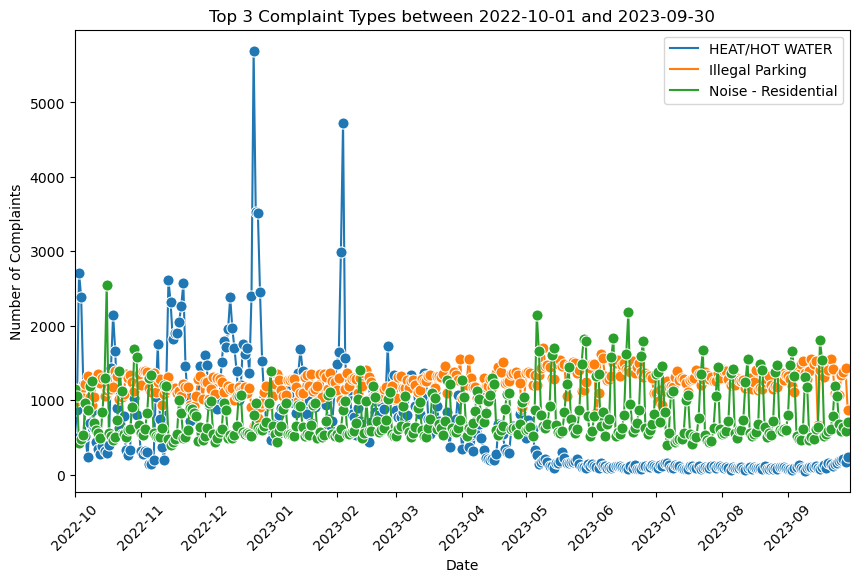

In [28]:
def visualize_top_complaints_over_time():
    """Visualizing top 3 complaints types between 2022-10-01 and 2023-09-30"""
    query = """
    WITH TopComplaints AS (
        SELECT complaint_type, COUNT(*) as total_count
        FROM "311_complaints"
        WHERE date >= '2022-10-01' AND date <= '2023-09-30'
        GROUP BY complaint_type
        ORDER BY total_count DESC
        LIMIT 3
    )
    SELECT tc.complaint_type, DATE(c.date) as date, COUNT(*) as count
    FROM "311_complaints" c
    JOIN TopComplaints tc ON c.complaint_type = tc.complaint_type
    WHERE c.date >= '2022-10-01' AND c.date <= '2023-09-30'
    GROUP BY tc.complaint_type, DATE(c.date)
    ORDER BY tc.complaint_type, date;
    """
    df = pd.read_sql_query(query, engine)
    df['date'] = pd.to_datetime(df['date'])

    plt.figure(figsize=(10, 6))

    # Use Seaborn lineplot
    sns.lineplot(data=df, x='date', y='count', hue='complaint_type', marker='o', markersize=8, linestyle='-')

    plt.xlim(pd.to_datetime('2022-10-01'), pd.to_datetime('2023-09-30'))
    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.title('Top 3 Complaint Types between 2022-10-01 and 2023-09-30')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

visualize_top_complaints_over_time()

### Visualization 2

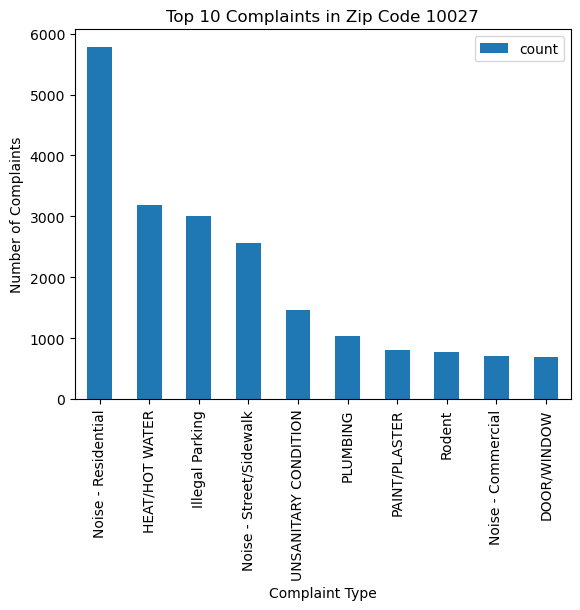

In [29]:
def visualize_top_complaints_10027():
    """Visualizaing top10 complaints type in zip code 10027 between 2018-10-01 and 2023-09-30"""
    query = """
    SELECT complaint_type, COUNT(*) as count
    FROM "311_complaints"
    WHERE zipcode = '10027' AND date >= '2018-10-01' AND date <= '2023-09-30'
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT 10;
    """
    df = pd.read_sql_query(query, engine)

    # Plotting
    df.plot(kind='bar', x='complaint_type', y='count', title='Top 10 Complaints in Zip Code 10027')
    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    plt.show()

visualize_top_complaints_10027()


### Visualization 3

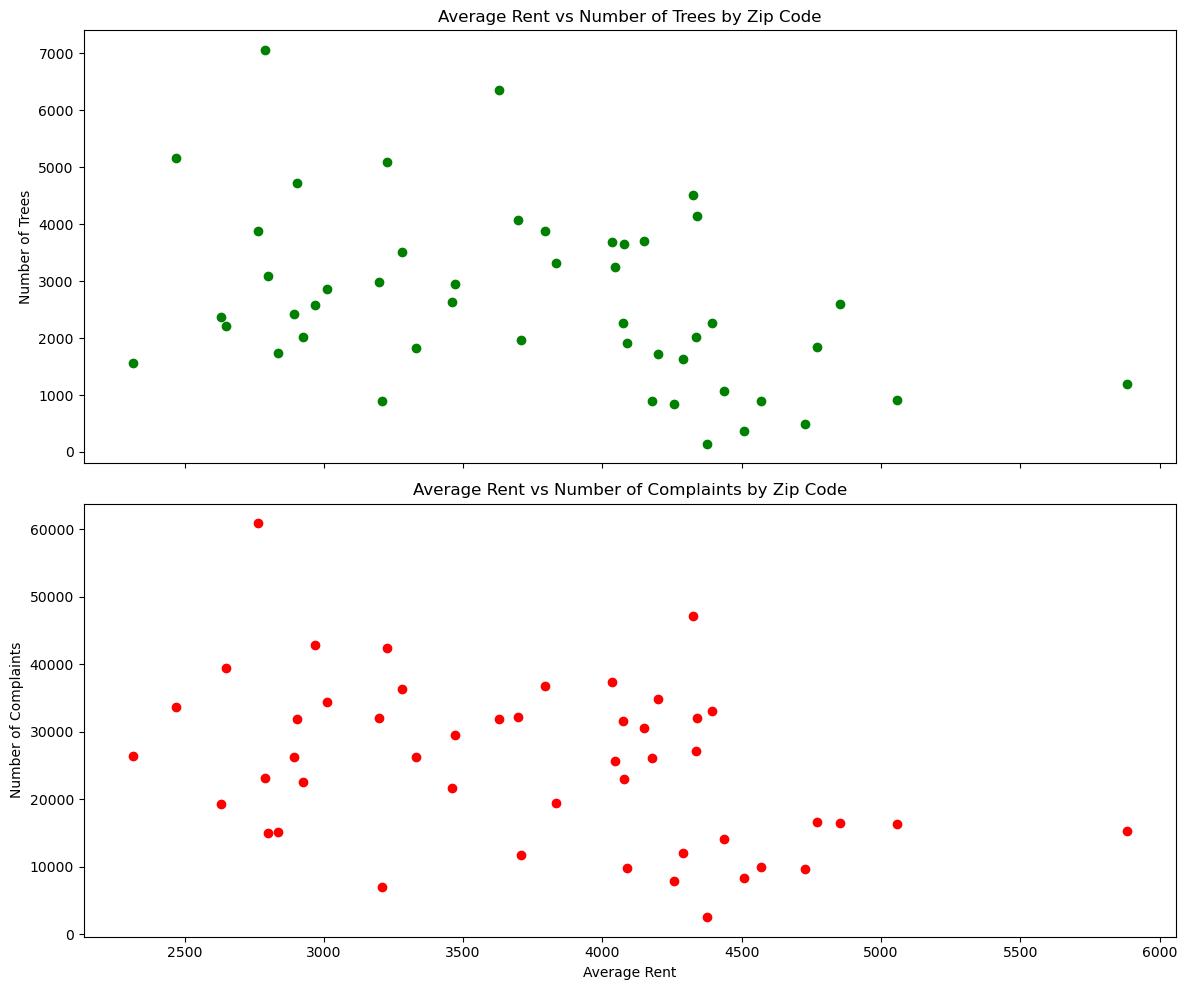

In [30]:
def visualize_rent_trees_complaints_correlation():
    """Visualizing correlation between rent, trees and complaints"""
    # SQL Query for average rent by zip code
    query_rent = """
    SELECT zipcode, AVG("2023-09-30") AS average_rent 
    FROM nyc_rents 
    WHERE "2023-09-30" IS NOT NULL 
    GROUP BY zipcode
    """
    df_rent = pd.read_sql(query_rent, engine)
    df_rent['zipcode'] = df_rent['zipcode'].astype('int64')
    
    # SQL Query for the number of trees by zip code
    query_trees = """
    SELECT zipcode, COUNT(*) AS tree_count 
    FROM nyc_trees 
    GROUP BY zipcode
    """
    df_trees = pd.read_sql(query_trees, engine)
    df_trees['zipcode'] = df_trees['zipcode'].astype('int64')
    
    # SQL Query for the number of complaints by zip code
    query_complaints = """
    SELECT zipcode, COUNT(*) AS complaint_count 
    FROM "311_complaints"
    WHERE date BETWEEN '2015-01-01' AND '2023-09-30' 
    GROUP BY zipcode
    """
    df_complaints = pd.read_sql(query_complaints, engine)
    df_complaints['zipcode'] = df_complaints['zipcode'].astype('int64')
    
    # Merging all data
    df_merged = df_rent.merge(df_trees, on='zipcode', how='outer').merge(df_complaints, on='zipcode', how='outer')
    df_merged.dropna(inplace=True)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Subplot1: Rent vs # of Trees
    ax1.scatter(df_merged['average_rent'], df_merged['tree_count'], color='green')
    ax1.set_title('Average Rent vs Number of Trees by Zip Code')
    ax1.set_ylabel('Number of Trees')

    # Subplot1: Rent vs # of Complaints
    ax2.scatter(df_merged['average_rent'], df_merged['complaint_count'], color='red')
    ax2.set_title('Average Rent vs Number of Complaints by Zip Code')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Number of Complaints')

    plt.tight_layout()
    plt.show()

visualize_rent_trees_complaints_correlation()


### Visualization 4

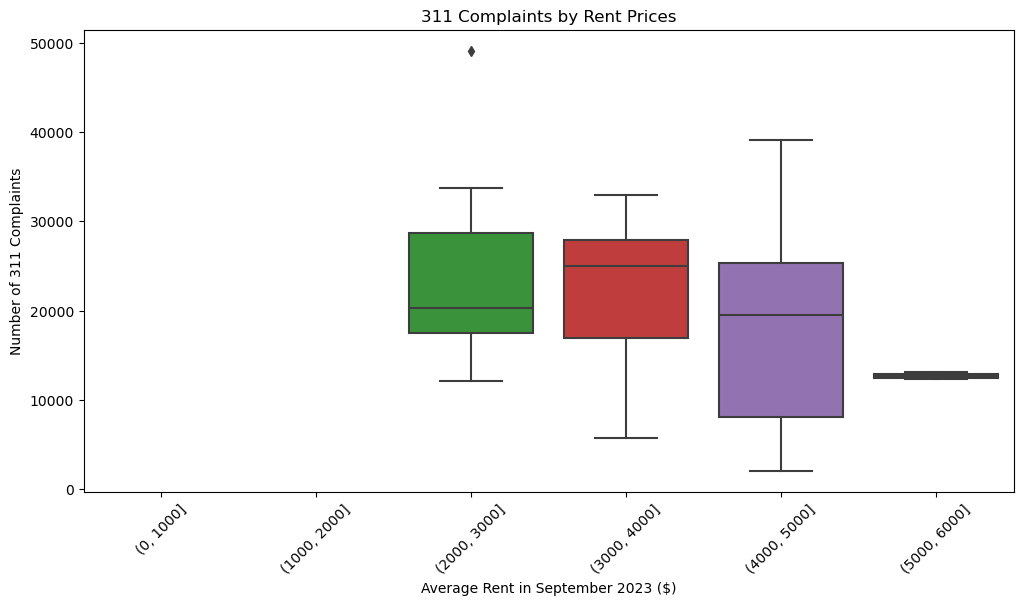

In [31]:
def visualize_rent_vs_complaints():
    """Visualizing average rent in 2023-09 and the number of complaints by zipcode"""
    query = """
    SELECT r.zipcode, r."2023-09-30" as average_rent,COUNT(c.complaint_id) as complaints_count
    FROM nyc_rents r
    JOIN "311_complaints" c ON r.zipcode = c.zipcode::bigint
    WHERE c.date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY r.zipcode, r."2023-09-30"
    """
    df = pd.read_sql(query, engine)
    df['rent_bin'] = pd.cut(df['average_rent'], bins=range(0, int(df['average_rent'].max()) + 1000, 1000))

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='rent_bin', y='complaints_count', data=df)
    plt.xticks(rotation=45)
    plt.xlabel("Average Rent in September 2023 ($)")
    plt.ylabel("Number of 311 Complaints")
    plt.title("311 Complaints by Rent Prices")
    plt.show()


visualize_rent_vs_complaints()

### Visualization 5

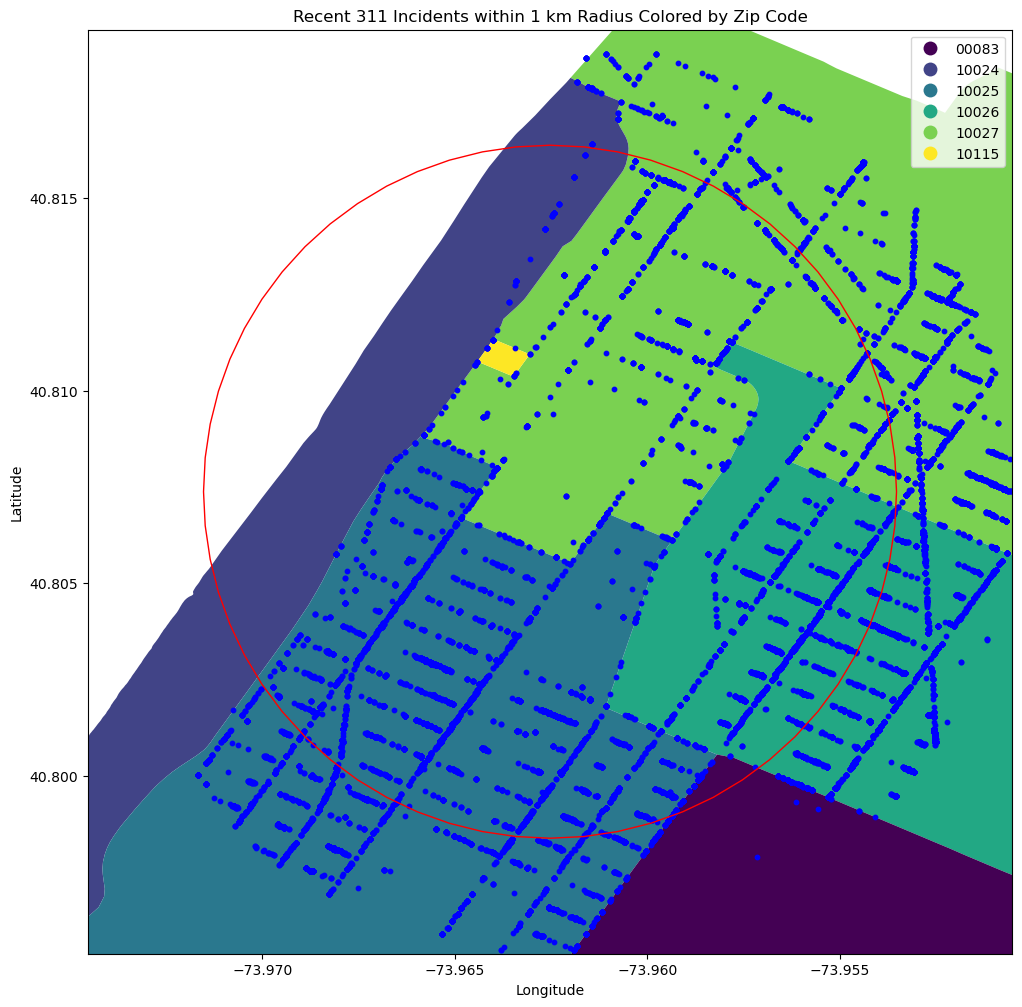

In [32]:
def visualize_complaints_within_1km(nyc_zipcode_shapefile, engine):
    """Visualizing the number of complaints in certain area"""
    # Loading NYC shapefile
    nyc_zipcodes = gpd.read_file(nyc_zipcode_shapefile)
    nyc_zipcodes = nyc_zipcodes.to_crs(epsg=4326)
    
    # Center from Query6
    center_lon, center_lat = -73.96253174434912, 40.80737875669467
    center_point = Point(center_lon, center_lat)

    # 1km area in degrees
    buffer = center_point.buffer(0.009)
    buffer_bound = center_point.buffer(0.012)
    
    # Filtering zip code within bound
    zipcodes_bound = nyc_zipcodes[nyc_zipcodes.intersects(buffer_bound)]

    # SQL Query for comoplaints between 2023-01-01 and 2023-09-30
    query = """
    SELECT latitude, longitude
    FROM "311_complaints"
    WHERE date BETWEEN '2023-01-01' AND '2023-09-30'
    """
    df = pd.read_sql(query, engine)

    # Filtering within the interested area
    df['within_buffer'] = df.apply(lambda row: Point(row['longitude'], row['latitude']).within(buffer_bound), axis=1)
    df_within_buffer = df[df['within_buffer']]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 12))
    zipcodes_bound.plot(ax=ax, column='ZIPCODE', cmap='viridis', legend=True)
    ax.scatter(df_within_buffer['longitude'], df_within_buffer['latitude'], color='blue', s=10)
    gpd.GeoSeries([buffer]).plot(ax=ax, edgecolor='red', facecolor='none')
    minx, miny, maxx, maxy = buffer_bound.bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title("Recent 311 Incidents within 1 km Radius Colored by Zip Code")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    
visualize_complaints_within_1km(nyc_zipcodes_shp_path, engine)

### Visualization 6

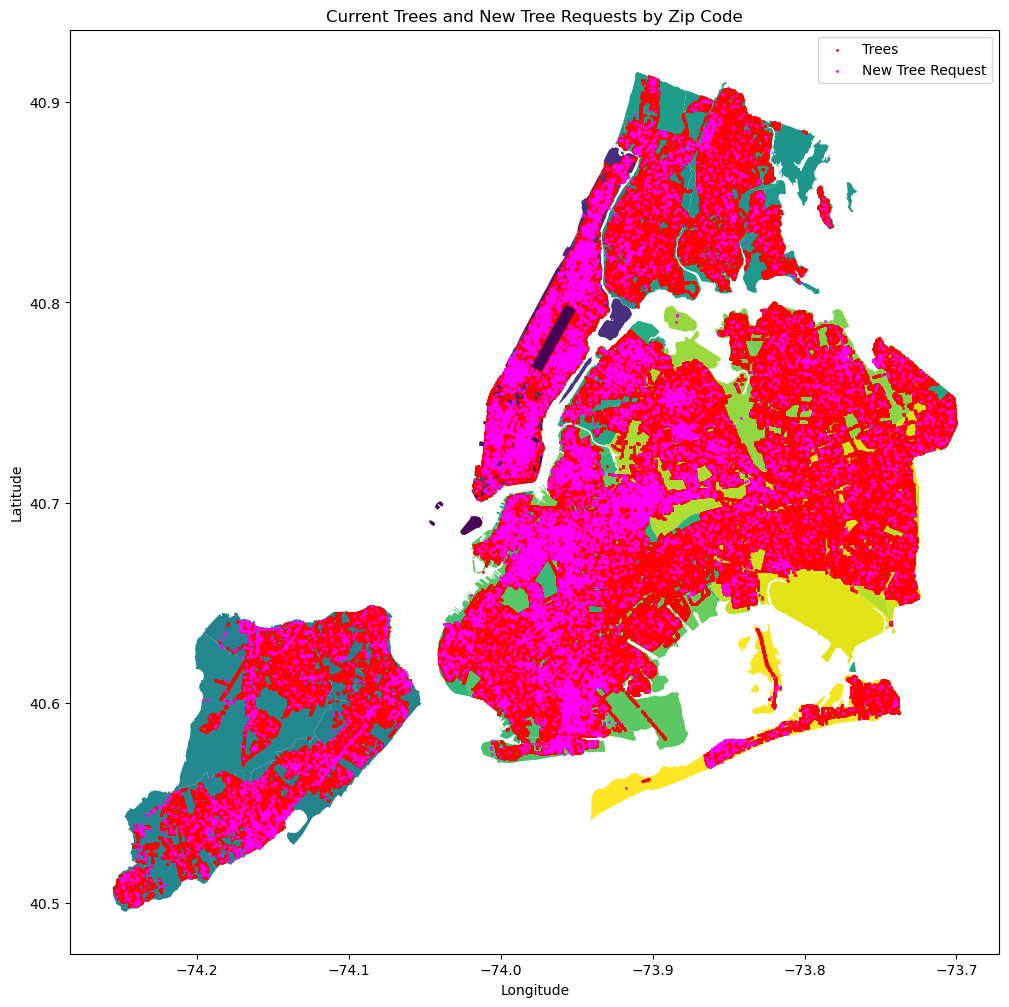

In [51]:
def visualize_current_tree_requests(nyc_shapefile, engine):
    """Visualizing tree locations and new tree requests by zip code"""
    # Loading NYC shapefile
    nyc_zipcodes = gpd.read_file(nyc_shapefile)
    nyc_zipcodes = nyc_zipcodes.to_crs(epsg=4326)

    # SQL Query for current tree location
    query_trees = """
    SELECT latitude, longitude
    FROM nyc_trees
    """
    df_trees = pd.read_sql_query(query_trees, engine)
    gdf_trees = gpd.GeoDataFrame(df_trees, geometry=gpd.points_from_xy(df_trees.longitude, df_trees.latitude))
    gdf_trees.set_crs(epsg=4326, inplace=True)

    # SQL Query for new tree requests
    query_new_tree_requests = """
    SELECT latitude, longitude
    FROM "311_complaints"
    WHERE complaint_type = 'New Tree Request' AND date BETWEEN '2018-10-01' AND '2023-09-30'
    """
    df_new_tree_requests = pd.read_sql_query(query_new_tree_requests, engine)
    gdf_new_tree_requests = gpd.GeoDataFrame(df_new_tree_requests, geometry=gpd.points_from_xy(df_new_tree_requests.longitude, df_new_tree_requests.latitude))
    gdf_new_tree_requests.set_crs(epsg=4326, inplace=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 12))
    nyc_zipcodes.plot(ax=ax, column='ZIPCODE', cmap='viridis', legend=True)
    ax.scatter(df_trees['longitude'], df_trees['latitude'], color='red', s=1, label='Trees')
    ax.scatter(df_new_tree_requests['longitude'], df_new_tree_requests['latitude'], color='magenta', s=1, label='New Tree Request')

    ax.set_title('Current Trees and New Tree Requests by Zip Code')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.legend()
    plt.show()
    
visualize_current_tree_requests(nyc_zipcodes_shp_path, engine)